In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin

Populating the interactive namespace from numpy and matplotlib


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Pull Daily Maximum Temperature for 2014_01_01

cida-eros-thredds url:http://cida-eros-thredds3.er.usgs.gov:8080/thredds/ncss/UofIMETDATA?var=max_air_temperature&north=49.4000&west=-124.7666&east=-67.0583&south=25.0666&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2014-01-01T00%3A00%3A00Z&time_end=2014-01-01T00%3A00%3A00Z&timeStride=1
file saved as UofIMETDATA_2014_01_01_tmax.nc

university of Idah url:http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2014-01-01T00%3A00%3A00Z&time_end=2014-01-01T00%3A00%3A00Z&timeStride=1&accept=netcdf
file saved as: agg_met_tmmx_1979_CurrentYear_CONUS_2014_01_01.nc

Open files using xarray

In [2]:
uofi_file = 'agg_met_tmmx_1979_CurrentYear_CONUS_2014_01_01.nc'
cida_file = 'UofIMETDATA_2014_01_01_tmax.nc'
ds = xr.open_dataset(uofi_file)
ds2 = xr.open_dataset(cida_file)
print('######################## university of idaho #############################################')
print(ds)
print('######################## cida #############################################')
print(ds2)

######################## university of idaho #############################################
<xarray.Dataset>
Dimensions:                    (day: 1, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2014-01-01
  * lat                        (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.400000000000006
    geospatial_lon_min:         -124.76666663333334
    geospatial_lon_max:         -67.05833330000002
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees

# Plot data sets

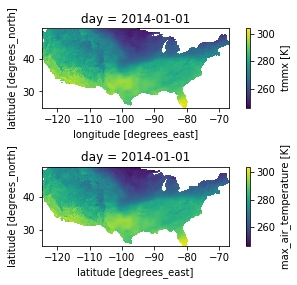

In [3]:
temp_uofi = ds.daily_maximum_temperature.isel(day=0)
temp_cida = ds2.max_air_temperature.isel(day=0)
fig, axes = plt.subplots(nrows=2)
axes[0].set_aspect(1)
axes[1].set_aspect(1)
plt.subplots_adjust(hspace=0.75)
temp_uofi.plot(ax=axes[0])
temp_cida.plot(ax=axes[1])

# Read NHM hru shapefiles into geopandas dataframe

B:\GitRepos\onhm-fetcher-parser-b\notebooks
..\Data


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


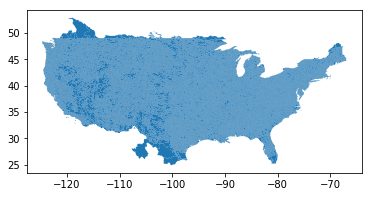

In [4]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
gdf.plot()
#print(gdf)


Map/interpolate raw netcdf daily_maximum_temperature to hru's using a file containing the contributing area of each netcdf cell to each hru, thus the hru value of daily_maximum_temperature is the area weighted average of the raw netcdf file

In [5]:
# add new column uofi_tmax dataframe
gdf['tmax']=0.0

#create some variables from the UofI netcdf file for use later
print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
datahandle=ds['daily_maximum_temperature']

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
# print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

#open weight data
wght_UofI = pd.read_csv('weights.csv')
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')
unique_hru_ids = wght_UofI.groupby('hru_id_nat')
print(len(gdf), len(unique_hru_ids))

def get_wval(grp, ndata):
    ttmax = twght = 0.0
    for index, row in grp.iterrows():
        ttmax += row['w']*ndata[np.int(row['grid_ids'])]
        twght += row['w']
    return ttmax/twght
def np_get_wval(grp, ndata):
    return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
#     return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
       
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
    weight_id_rows = unique_hru_ids.get_group(row['hru_id_nat'])
#     print(weight_id_rows['grid_ids'].values.astype(int))
#     unique_hru_ids.get_group(row['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})
#     gdf.loc[gdf.index[index],'tmax'] = np_get_wval(weight_id_rows, ndata)-273.5
    tmp = np_get_wval2(weight_id_rows, ndata)-273.5
    if index == 1:
        print(type(tmp))
    td[index] = np_get_wval2(weight_id_rows, ndata)-273.5
 
gdf['tmax'] = td.tolist()
gdf['tmax'].fillna(0.0)
# print(td.tolist())
print('min/max', gdf['tmax'].min(), gdf['tmax'].max())



 The meta data is: 
 {
    "geospatial_bounds_crs": "EPSG:4326",
    "Conventions": "CF-1.0",
    "geospatial_bounds": "POLYGON((-124.7666666333333 49.400000000000000, -124.7666666333333 25.066666666666666, -67.058333300000015 25.066666666666666, -67.058333300000015 49.400000000000000, -124.7666666333333 49.400000000000000))",
    "geospatial_lat_min": 25.066666666666666,
    "geospatial_lat_max": 49.400000000000006,
    "geospatial_lon_min": -124.76666663333334,
    "geospatial_lon_max": -67.05833330000002,
    "geospatial_lon_resolution": "0.041666666666666",
    "geospatial_lat_resolution": "0.041666666666666",
    "geospatial_lat_units": "decimal_degrees north",
    "geospatial_lon_units": "decimal_degrees east",
    "coordinate_system": "EPSG:4326",
    "author": "John Abatzoglou - University of Idaho, jabatzoglou@uidaho.edu",
    "date": "02 July 2019",
    "note1": "The projection information for this file is: GCS WGS 1984.",
    "note2": "Citation: Abatzoglou, J.T., 2013, Deve

C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Warning: converting a masked element to nan.


min/max -25.46058623332516 30.100006103515682


In [7]:
gdf.sort_values(by=['hru_id_nat'])
cbh_data = pd.read_csv('tmax.cbh', sep=' ', header = None, skiprows = 12787, nrows = 1)
print(cbh_data.head())
gdf['cbhtmax'] = 0.0
# tmp = (cbh_data.iloc[0, 6:] -32.0) * (5/9)
gdf['cbhtmax'][0:] = (cbh_data.iloc[0, 6:] -32.0) * (5/9)

   0       1       2       3       4       5       6       7       8       \
0    2014       1       1       0       0       0    3.82    6.31    6.26   

   9       ...  109947  109948  109949  109950  109951  109952  109953  \
0    5.49  ...   61.59    57.6    55.2   54.96   63.66   63.64   58.42   

   109954  109955  109956  
0    56.8   60.48   58.71  

[1 rows x 109957 columns]


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
nc_cbh_data = xr.open_dataset('idaho_cbh_all_20140101-20141231.nc')
nc_cbh_data

,LAYER,POI_ID,geometry,hru_id_nat,hru_id_reg,region,tmax,cbhtmax
0,NaN,7733855,POLYGON ((-73.37147648799998 41.11232830300003...,1,1,01,-0.205686,-15.655556
1,NaN,7733919,POLYGON ((-73.38531621599998 41.13467480400004...,2,2,01,-0.365955,-14.272222
2,NaN,7732571,POLYGON ((-73.41946539799994 41.16068341300007...,3,3,01,-0.399994,-14.300000
3,NaN,7732387,POLYGON ((-73.41096625099993 41.15832593000005...,4,4,01,-0.399994,-14.727778
4,NaN,7733327,(POLYGON ((-73.28636293699998 41.1278083500000...,5,5,01,0.070898,-15.244444


In [ ]:
nc_tmax = nc_cbh_data.tmax[0,:]
nc_tmax.data
gdf['nccbhtmax'] = 0.0
gdf['nccbhtmax'][0:] = (nc_tmax.data[0:] -32.0) * (5/9)

C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


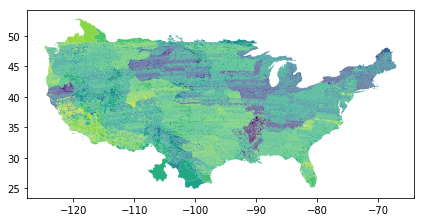

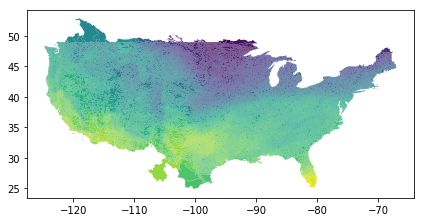

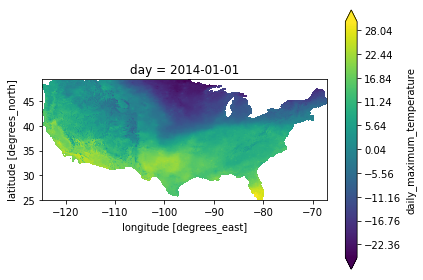

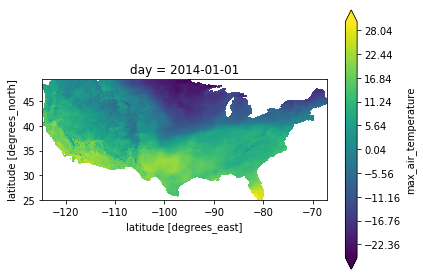

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


f, ax = plt.subplots(1)
ax.set_aspect('equal')
# ax.axis('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
# divider_0 = make_axes_locatable(ax[0])
# cax_0 = divider_0.append_axes("right", size="5%", pad=0.1)
lvs = np.arange(gdf['cbhtmax'].min(), gdf['cbhtmax'].max(), 0.1)
gdf.plot(ax=ax, column = 'cbhtmax',linewidth=0., edgecolor='white', cmap='viridis', k=20)
f.savefig('hru_cbh.png')
f.tight_layout()

g, ax2 = plt.subplots(1)
ax2.set_aspect('equal')
# ax.axis('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
# divider_0 = make_axes_locatable(ax[0])
# cax_0 = divider_0.append_axes("right", size="5%", pad=0.1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.1)
gdf.plot(ax=ax2, column = 'tmax',linewidth=0., edgecolor='white', cmap='viridis', k=20)
g.savefig('hru_mapped_gridmet.png')
g.tight_layout()

f1, ax1 = plt.subplots(1)
ax1.set_aspect('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
ptmax = ds.daily_maximum_temperature-273.5
ptmax_1 = ptmax.isel(day=dayshape-1)
ptmax_1.plot(ax=ax1, levels=lvs, cmap='viridis')
f1.tight_layout()
f1.savefig('gridmet.png')

f2, ax2 = plt.subplots(1)
ax2.set_aspect('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
ptmax = ds2.max_air_temperature-273.5
ptmax_1 = ptmax.isel(day=0)
ptmax_1.plot(ax=ax2, levels=lvs, cmap='viridis')
f2.tight_layout()
f2.savefig('cida_gridmet.png')

In [ ]:
gdf.head(5000)

In [28]:
shape(gdf['geometry'].area)
type(gdf['geometry'].area)
type(gdf['geometry'].area.values)

numpy.ndarray

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002403F9E48D0>]],
      dtype=object)

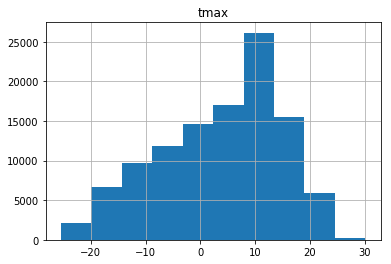

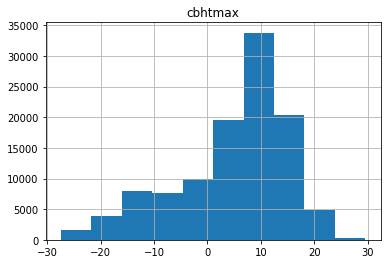

In [11]:
gdf.hist('tmax')
gdf.hist('cbhtmax')

In [27]:
gdf['tmax'].plot(kind='hist', weights=np.ones_like(gdf['geometry'].area.values)

SyntaxError: unexpected EOF while parsing (<ipython-input-27-392f7265c2e1>, line 1)